In [1]:
from pathlib import Path
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import re
from gelgenie.segmentation.helper_functions.general_functions import create_dir_if_empty, index_converter
from collections import defaultdict
import pickle
import math
from scipy.stats import linregress
import pingouin
import copy
plt.rcParams.update({'font.sans-serif':'Helvetica'})  # consistent figure formatting

### Conducting Linear Regression on Main Dataset

#### The band data for this notebook needs to be generated by running generate_segmentation_dataset_for_figure_1.py first.  Filepaths will need to be arranged for your own system.

In [27]:
def hidden_linreg(target, ref, num_hide=3, num_reps=10):
    # Main evaluation function for a gel lane -
    # hides a number of bands, attempts to linear fit the remaining bands and then predicts the value of the unseen bands

    # Initialize an empty list to store the selected sets
    selected_sets = set()
    
    # Loop to select unique sets
    for _ in range(num_reps):
        # Select the first num_hide numbers as a set
        selected_set = tuple(np.random.choice(range(len(target)), num_hide, replace=False))
        # Check if the set is already selected
        while selected_set in selected_sets:
            selected_set = tuple(np.random.choice(range(len(target)), num_hide, replace=False))
        selected_sets.add(selected_set)

    errors = []
    full_errors = []
    full_no_abs_errors = []
    for combo in selected_sets:
        tfrac, rfrac = [t for ind, t in enumerate(target) if ind not in combo], [r for ind, r in enumerate(ref) if ind not in combo]
        slope, intercept, r_value, p_value, std_err = linregress(tfrac, rfrac)
        pred_hidden = [slope * target[sel_ind] + intercept for sel_ind in combo]
        ref_hidden = [ref[sel_ind] for sel_ind in combo]
        percentage_errors = [(np.abs(t-p)/t)*100 for t,p in zip(ref_hidden, pred_hidden)]
        perc_no_abs_errors = [((t-p)/t)*100 for t,p in zip(ref_hidden, pred_hidden)]
        errors.append(np.average(percentage_errors))
        full_errors.extend(percentage_errors)
        full_no_abs_errors.extend(perc_no_abs_errors)
    return errors, full_errors, full_no_abs_errors, (slope, intercept, combo)
    

In [28]:
# Full dataset loaded in here
data_pack = pickle.load(open('/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/ladder_eval/combined_data_with_erosions_dilations_and_gelanalyzer.pkl','rb'))
for key,val in data_pack.items():
    data_pack[key]['Rectangularity'] = data_pack[key]['Pixel Count']/(data_pack[key]['Band Width']*data_pack[key]['Band Height'])
non_data_cols = ['Lane ID', 'Band ID', 'Rectangularity', 'Band Height', 'Band Width', 'Pixel Count', 'Ref.', 'Pixel STD']

In [29]:
data_pack.keys()

dict_keys(['0_Thermo', '1_Thermo', '2_Thermo', '3_Thermo', '4_Thermo', '5_Thermo', '6_Thermo', '7_Thermo', '8_Thermo', '9_Thermo', '10_Thermo', '11_Thermo', '12_Thermo', '13_NEB', '14_NEB', '15_NEB', '16_NEB', '17_NEB', '18_NEB', '19_NEB', '20_NEB', '21_NEB', '22_NEB', '23_NEB', '24_NEB', '29_NEB', '31_NEB', '32_Thermo', '33_NEB', '34_Thermo'])

In [30]:
# Additional GG-direct data loaded here (mainly to get global + local background correction)
def load_gg_csv_files_to_dict(folder_path, prefix="prefix_"):
    """
    Load CSV files from a folder and create a dictionary of DataFrames with prefixed keys.

    Parameters:
    - folder_path (str): The path to the folder containing CSV files.
    - prefix (str): The prefix to be added to the keys of the dictionary (default is "prefix_").

    Returns:
    - dataframes_dict (dict): A dictionary where keys are prefixed numbers, and values are corresponding DataFrames.
    """
    dataframes_dict = {}  # Dictionary to store DataFrames

    # Iterate through files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a CSV file
        if filename.endswith(".csv"):
            # Extract the number from the filename
            file_number = filename.split("_")[0]

            # Read the CSV file into a DataFrame
            file_path = os.path.join(folder_path, filename)
            dataframe = pd.read_csv(file_path)

            # Add the prefix to the number and use it as the key in the dictionary
            key = f"{prefix}{file_number}"
            dataframes_dict[key] = dataframe
    return dataframes_dict

gg_path = Path("/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/quantitative_evaluation/ladder_eval/qupath_data/james_data_v3_fixed_global/Data_with_norm_and_corrections")
gg_dfs = load_gg_csv_files_to_dict(gg_path, "gg_") # loads data and converts to dictionary
gg_dfs = {key: gg_dfs[key] for key in sorted(gg_dfs.keys(), key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)])}  # sorts by gel ID

In [31]:
# combines GG-direct background corrected vals with the main data pack
for key, val in data_pack.items():
    gg_df = gg_dfs['gg_%s' % key.split('_')[0]][['Local Corrected Volume', 'Global Corrected Volume', 'Lane ID', 'Band ID']]
    data_pack[key] = pd.merge(val, gg_df, on=['Lane ID', 'Band ID'])

In [32]:
# example dataset from one gel
data_pack['0_Thermo'][data_pack['0_Thermo']['Lane ID'] == 12]

,Raw,RB Corrected,Lane ID,Band ID,Ref.,Pixel Count,Band Width,Band Height,Pixel Average,Pixel STD,...,dilation 1 BC,dilation 2,dilation 2 BC,random adjustment 1,random adjustment 1 BC,GA-Raw-Vol,GA-BC-Vol,Rectangularity,Local Corrected Volume,Global Corrected Volume
11,13406,8517,12,1,20,434,51,9,30.889401,6.124795,...,9488,17762,10012,10544,6960,337,181,0.945534,7129.462069,8229.284167
23,16358,11097,12,2,20,425,52,10,38.489412,9.072026,...,12208,21307,12752,19070,12208,420,233,0.817308,9752.509202,11288.635417
35,16314,10949,12,3,20,402,51,9,40.582090,8.709775,...,12295,21718,12974,12387,8582,429,232,0.875817,8841.154557,11518.977500
47,15671,10914,12,4,20,355,51,8,44.143662,7.425437,...,12603,21587,13476,18990,12603,446,233,0.870098,8470.185734,11436.589583
59,15581,10641,12,5,20,391,50,9,39.849105,6.858470,...,11840,20659,12537,15581,10641,447,220,0.868889,8888.061415,10917.184583
71,18032,12533,12,6,20,464,49,11,38.862069,9.096842,...,13506,22551,13989,14569,10462,441,266,0.860853,11167.793548,12497.446667
83,16598,11438,12,7,20,438,49,10,37.894977,7.268681,...,12577,21227,13131,13169,9346,410,242,0.893878,9974.283019,11373.572500
95,16440,11824,12,8,20,421,49,10,39.049881,7.085825,...,13298,21403,14011,19260,13298,416,260,0.859184,10010.181818,11418.347083
107,16617,12106,12,9,20,411,48,9,40.430657,7.855875,...,13733,21726,14559,16617,12106,424,260,0.951389,9996.390738,11714.626250
119,48661,41796,12,10,70,541,49,13,89.946396,19.401557,...,46256,58987,48684,54800,46256,1226,968,0.849294,34933.125000,42207.997083


In [33]:
# linear regression for dataset carried out here
# All data except lane 2 of 14,15,16 are considered (the lane was impacted by the high-temp gel running and bands cannot be accurately defined)
blind_pred_dict = defaultdict(list)
all_error_dict = defaultdict(list)
all_error_no_abs_dict = defaultdict(list)
descriptor_dict = defaultdict(list)
high_intensity = ['3_Thermo','4_Thermo', '6_Thermo', '7_Thermo','8_Thermo', '10_Thermo','11_Thermo', '12_Thermo', '17_NEB', '19_NEB', '20_NEB', '21_NEB', '24_NEB', '29_NEB', '31_NEB', '32_Thermo', '33_NEB']
low_intensity = ['0_Thermo','1_Thermo', '2_Thermo', '5_Thermo', '9_Thermo', '13_NEB', '14_NEB', '15_NEB', '16_NEB', '18_NEB', '22_NEB', '23_NEB', '34_Thermo' ]

np.random.seed(12)

for big_key in data_pack.keys():
    sel_df = data_pack[big_key]
    ladder_type = 'NEB'
    if 'Thermo' in big_key:
        ladder_type = 'ThermoFisher'
    for col_index, column in enumerate(sel_df.columns):
        if column in non_data_cols:
            continue
        if ' BC' in column and 'Raw' not in column:
            continue
        for lane in np.unique(sel_df['Lane ID']):

            if lane == 2 and big_key in ['14_NEB', '16_NEB', '17_NEB']:
                continue

            ref = sel_df[sel_df['Lane ID'] == lane]['Ref.'].to_numpy()
            target = sel_df[sel_df['Lane ID'] == lane][column].to_numpy()
            errors, full_errors, full_no_abs_errors, (slope, intercept, combo) = hidden_linreg(target, ref, 5, 80)
            blind_pred_dict[column].append(np.average(errors))
            all_error_dict[column].extend(full_errors)
            all_error_no_abs_dict[column].extend(full_no_abs_errors)
            
            if column == 'Raw': # adds one time data for each lane e.g. rectangularity level, etc.
                rectangularity_sum = np.sum(sel_df[sel_df['Lane ID'] == lane]['Rectangularity'].to_numpy())/len(ref)
                descriptor_dict['Rectangularity'].append(rectangularity_sum)
    
                pixel_av = np.sum(sel_df[sel_df['Lane ID'] == lane]['Pixel Average'].to_numpy())/len(ref)
                if pixel_av > 255: # 16-bit norm
                    pixel_av = pixel_av/65535
                else: # 8-bit norm
                    pixel_av = pixel_av/255
                    
                descriptor_dict['Pixel Average'].append(pixel_av)
                descriptor_dict['Gel Name'].append(big_key)
                blind_pred_dict['Ladder'].append(ladder_type)
                blind_pred_dict['Gel'].append(big_key)

                all_error_no_abs_dict['Ladder'].extend([ladder_type]*len(full_no_abs_errors))
                
                if big_key in high_intensity:
                    descriptor_dict['Gel Intensity'].append('High')
                else:
                    descriptor_dict['Gel Intensity'].append('Low')


blind_df = pd.DataFrame.from_dict(blind_pred_dict)
blind_df_all = pd.DataFrame.from_dict(all_error_dict) # this isn't necessary, but nice to have
blind_df_all_no_abs = pd.DataFrame.from_dict(all_error_no_abs_dict)
descriptor_df = pd.DataFrame.from_dict(descriptor_dict)

In [34]:
blind_df.describe()

,Raw,RB Corrected,Pixel Average,erosion 1,erosion 2,dilation 1,dilation 2,random adjustment 1,GA-Raw-Vol,GA-BC-Vol,Local Corrected Volume,Global Corrected Volume
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,22.281930,23.513404,36.287365,22.755937,24.177506,22.640613,22.928907,29.633055,25.231681,22.161745,28.779462,24.224298
std,9.025110,8.914731,9.918931,8.190946,8.170449,9.605174,10.072287,8.811841,10.731327,10.223068,7.088483,9.023381
min,8.232694,6.837770,16.580683,7.818031,9.527695,8.479042,8.169985,11.676195,6.564939,5.786919,16.476707,7.616325
25%,14.181964,15.525397,29.984008,16.325570,17.176908,13.761317,13.557384,24.278084,15.406210,13.014525,23.512569,16.435317
50%,20.647840,22.484905,34.636660,22.295709,23.566044,20.151244,19.637928,28.962791,26.496280,20.127173,28.018737,22.061214
75%,30.016745,30.049041,39.787964,29.064368,30.694330,30.878176,32.445804,34.792096,34.309692,30.569588,32.561860,32.628404
max,46.784112,41.096016,89.723034,50.113237,52.052286,43.844275,48.004233,112.721163,53.790824,42.197239,50.192139,48.660456


In [38]:
blind_df[blind_df['Ladder']=='ThermoFisher'].describe()

,Raw,RB Corrected,Pixel Average,erosion 1,erosion 2,dilation 1,dilation 2,random adjustment 1,GA-Raw-Vol,GA-BC-Vol,Local Corrected Volume,Global Corrected Volume
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,24.272186,26.038368,32.001588,23.219481,21.957916,24.882713,24.921171,27.848697,23.858124,23.699923,29.357566,26.946632
std,9.582624,9.316535,5.371918,8.911420,7.760374,10.190287,10.415001,6.511560,10.232223,11.490731,5.958985,8.794936
min,9.113910,10.058569,16.580683,10.108290,9.527695,8.479042,8.169985,11.676195,6.564939,5.786919,17.099276,10.899959
25%,14.325487,16.511934,28.579700,14.418902,15.937560,14.001263,13.608209,22.837266,13.280931,11.098904,24.592012,17.829861
50%,24.845245,27.179712,32.875592,22.753060,20.558765,27.098978,28.350563,27.873093,27.132528,27.231014,29.061971,28.647653
75%,33.623490,34.943879,36.055510,31.506965,27.373423,34.457082,35.026353,32.964467,33.104763,34.577172,34.215635,34.820363
max,40.565809,41.096016,44.260359,41.142673,40.236167,40.465985,40.580358,41.140209,43.333672,42.197239,40.371911,41.491473


In [39]:
blind_df[blind_df['Ladder']=='NEB'].describe()

,Raw,RB Corrected,Pixel Average,erosion 1,erosion 2,dilation 1,dilation 2,random adjustment 1,GA-Raw-Vol,GA-BC-Vol,Local Corrected Volume,Global Corrected Volume
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,18.769714,19.057585,43.850502,21.937918,28.094431,18.683965,19.413148,32.781921,27.655606,19.447314,27.759278,19.420179
std,6.660042,5.988619,11.492581,6.697720,7.397361,6.919263,8.393758,11.189233,11.204864,6.716016,8.672693,7.275002
min,8.232694,6.837770,25.574156,7.818031,11.624687,8.734276,9.199546,12.652535,10.342943,8.510144,16.476707,7.616325
25%,13.987562,15.111854,35.172183,17.571337,23.709594,13.476939,13.450352,27.395991,17.260413,14.169697,21.205341,15.042305
50%,17.821958,17.709247,43.242475,21.886272,28.826727,16.705458,16.896497,31.252053,26.077068,17.525723,26.280748,17.152694
75%,22.297570,22.519411,50.392681,25.957459,33.194088,21.659837,21.378712,38.170411,35.641226,24.100485,29.773244,21.831231
max,46.784112,38.905384,89.723034,50.113237,52.052286,43.844275,48.004233,112.721163,53.790824,40.059665,50.192139,48.660456


### Figure 1B - Individual Plots Showing Linear Regression

In [18]:
sel_df = data_pack['23_NEB']
lane = 2
ref = sel_df[sel_df['Lane ID'] == lane]['Ref.'].to_numpy()
target = sel_df[sel_df['Lane ID'] == lane]['Raw'].to_numpy()
np.random.seed(12)
sns.set(style="ticks")

for lane in [4]:
    for i in range(10):
        selected_sets = set()
        num_hide = 5
         
        # Select the first num_hide numbers as a set
        selected_set = tuple(np.random.choice(range(len(target)), num_hide, replace=False))
        # Check if the set is already selected
        while selected_set in selected_sets:
            selected_set = tuple(np.random.choice(range(len(target)), num_hide, replace=False))
        selected_sets.add(selected_set)
        combo = next(iter(selected_sets))
    
        tfrac, rfrac = [t for ind, t in enumerate(target) if ind not in combo], [r for ind, r in enumerate(ref) if ind not in combo]
        linreg_result = linregress(tfrac, rfrac)
        slope = linreg_result.slope
        intercept = linreg_result.intercept
    
        pred_hidden = [slope * target[sel_ind] + intercept for sel_ind in combo]
        ref_hidden = [ref[sel_ind] for sel_ind in combo]
        target_hidden = [target[sel_ind] for sel_ind in combo]
        fig, ax = plt.subplots()
    
        y_data = range(0,int(np.max(target)))
        x_data = slope*y_data + intercept
        
        sns.lineplot(x=x_data, y=y_data, 
                     linestyle='dashed', c='#ff7c00', label='Linear Fit', linewidth=2.5, zorder=5)
        
        plt.scatter(rfrac, tfrac, c='#023eff', label='Bands used for Fit',edgecolors='black', linewidth=1, zorder=6, s=60)
        plt.scatter(ref_hidden, target_hidden,c='#1ac938', label='Unseen Band Ground Truth',edgecolors='black', 
                    linewidth=1, zorder=7, s=60, marker='^')
        plt.scatter(pred_hidden, target_hidden, c='#e8000b', label='Unseen Band Prediction',edgecolors='black', 
                    linewidth=1, marker='X', zorder=8, s=90)
    
    
        # sns.regplot(x=rfrac, y=tfrac)
        plt.legend(fontsize=13)
        plt.xlabel('Band Weight (ng)', fontsize=25)
        plt.ylabel('Band Volume (A.U.)', fontsize=25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.yticks(fontsize=20)
        plt.xticks(fontsize=20)
        plt.tight_layout()
        plt.savefig('/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/manuscript/figures/metric_plots/human_seg_analysis/linear_plots/v2_plots/%s_%s.pdf' % (lane, i), dpi=300)
        plt.show()
        plt.close()    
    
    
    # plt.ylim([0,70000])
    

## Figure 1B Main Plot - Comparing GA vs GG

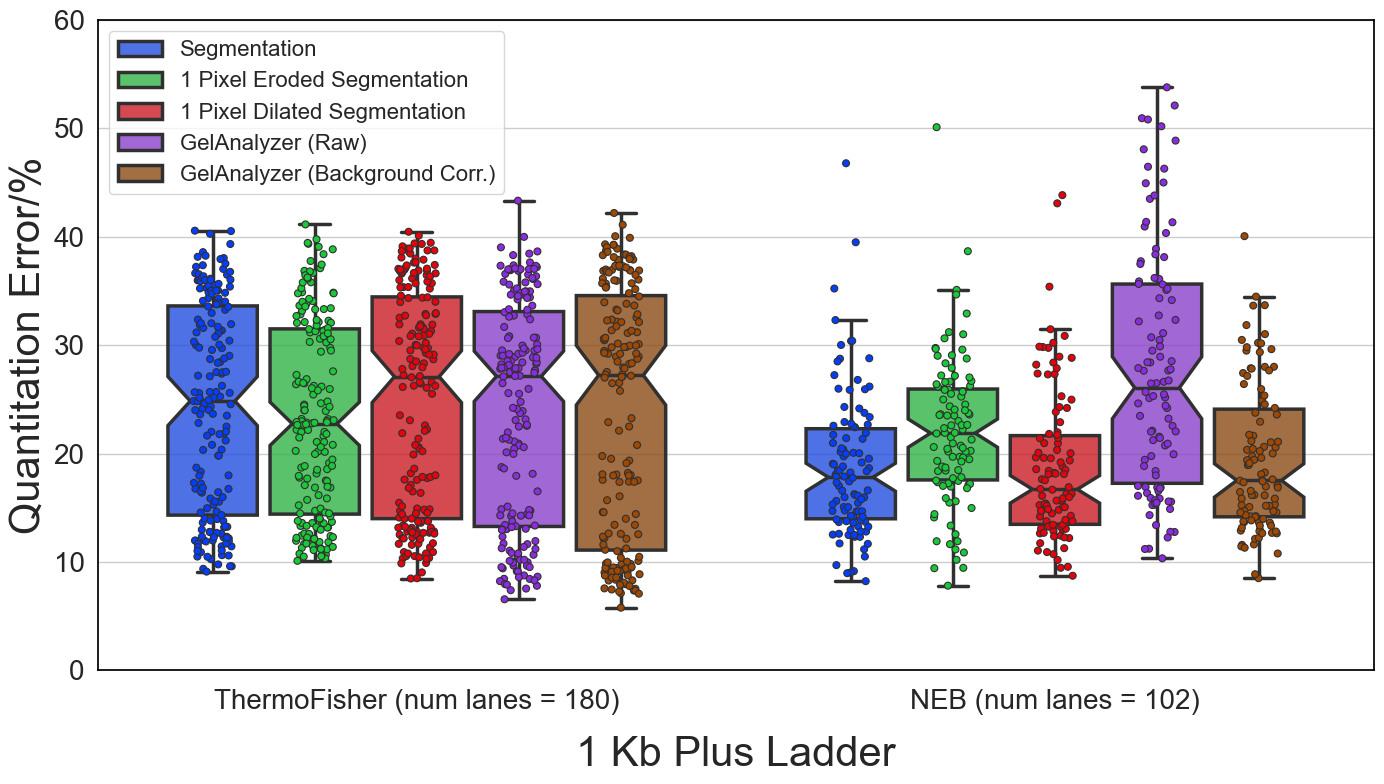

In [41]:
# for now, random adjustment and additional erosion/dilation are unneccessary.  Will add these to supp info.
df_adjusted = blind_df.drop(columns=['Pixel Average', 'RB Corrected', 'random adjustment 1', 'erosion 2', 'dilation 2', 'Local Corrected Volume', 'Global Corrected Volume', 'Gel'])
df_adjusted.rename(columns={"Raw":"Segmentation", 
                            # "RB Corrected":"Manual + Rolling Ball Background Correction", 
                            "erosion 1":"1 Pixel Eroded Segmentation", 
                            "dilation 1":"1 Pixel Dilated Segmentation", 
                            "GA-Raw-Vol":"GelAnalyzer (Raw)", 
                            "GA-BC-Vol":"GelAnalyzer (Background Corr.)"}, inplace=True)
df_melted = pd.melt(df_adjusted, id_vars=['Ladder'], var_name='Values')
plt.figure(figsize=(14,8))

# sel_palette = "bright"
sel_palette = ['#023eff', '#1ac938', '#e8000b', '#8b2be2', '#9f4800']

sns.set(style="whitegrid")
# ax = sns.violinplot(x='Ladder', y='value', hue='Values', data=df_melted, legend=False, fill=False, palette=sel_palette)
ax = sns.boxplot(x='Ladder', y='value', hue='Values', data=df_melted, showfliers=False, 
                 notch=True, gap=.4, widths=[0.14, 0.14], palette=sel_palette, linewidth=2.5)
ax.tick_params(axis='x', labelsize=20, size=10)
ax.set_xticks(ax.get_xticks()) # just to silence annoying warning
ax.set_xticklabels(['ThermoFisher (num lanes = %s)' % sum(blind_df["Ladder"] == "ThermoFisher"),'NEB (num lanes = %s)' % sum(blind_df["Ladder"] == "NEB")])
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
# sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.1, legend=False, dodge=True, alpha=0.4, marker="$\circ$", palette="dark") 
sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.15, legend=False, dodge=True, 
              alpha=1.0, marker="o", palette=sel_palette, linewidth=0.8) 

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
# sns.despine(offset=10, trim=False)
plt.xlabel('1 Kb Plus Ladder', fontsize=30, labelpad=15)
plt.ylabel('Quantitation Error/%', fontsize=30)
plt.yticks(fontsize=20)
plt.ylim([0,60])
ax.legend(fontsize=16)
plt.tight_layout()
plt.savefig('/Users/matt/Desktop/ladder_comp_seg_human_dataset.pdf')
pass

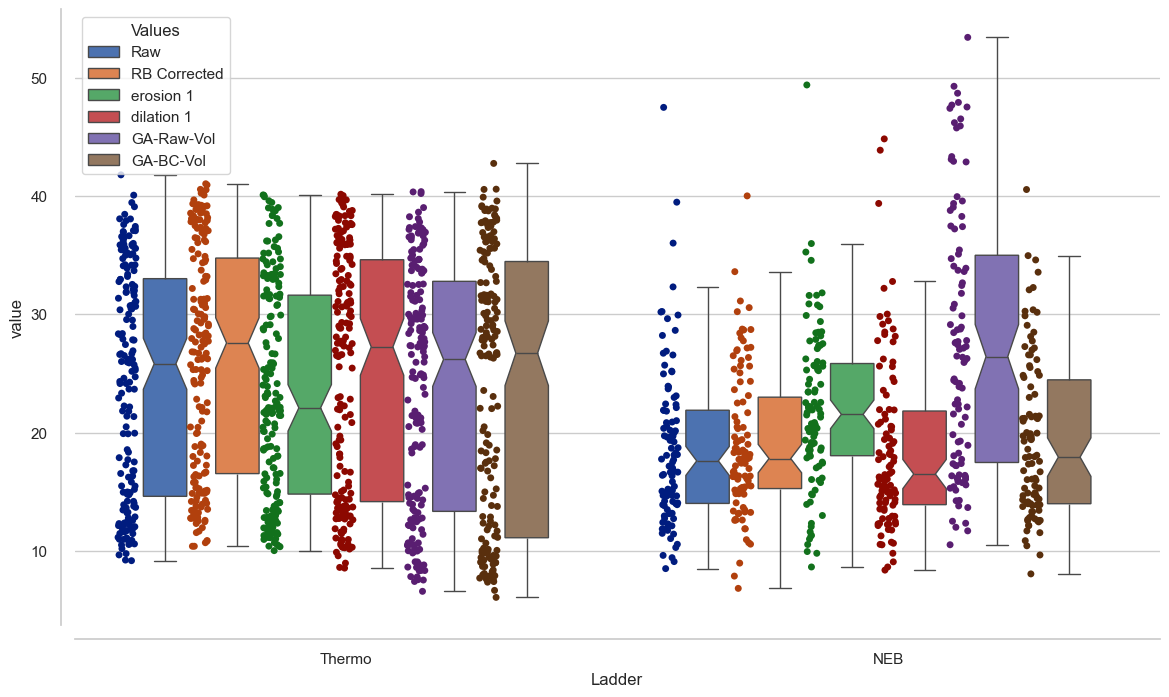

In [365]:
# alternative visualization - other version preferred
import matplotlib
df_melted = pd.melt(blind_df.drop(columns=['Pixel Average', 'random adjustment 1', 'erosion 2', 'dilation 2']), id_vars=['Ladder'], var_name='Values')

plt.figure(figsize=(14,8))
ax = sns.boxplot(x='Ladder', y='value', hue='Values', data=df_melted, showfliers=False, notch=True, gap=.4, saturation=1.5)
stripplot = sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.1, legend=False, dodge=True, marker="o", palette="dark") 
sns.despine(offset=10, trim=False)

# Adjust stripplot positions
for i, artist in enumerate(stripplot.get_children()):
    if isinstance(artist, matplotlib.collections.PathCollection):
        new_pos = [p - 0.07  for p in artist.get_offsets()[:, 0]]
        artist.set_offsets(list(zip(new_pos, artist.get_offsets()[:, 1])))

pass

### Individual Gel Boxplots - Extended Data Figure 1

/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_2105/3153880169.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdf['Order'] = bdf['Gel'].map(order_mapping)


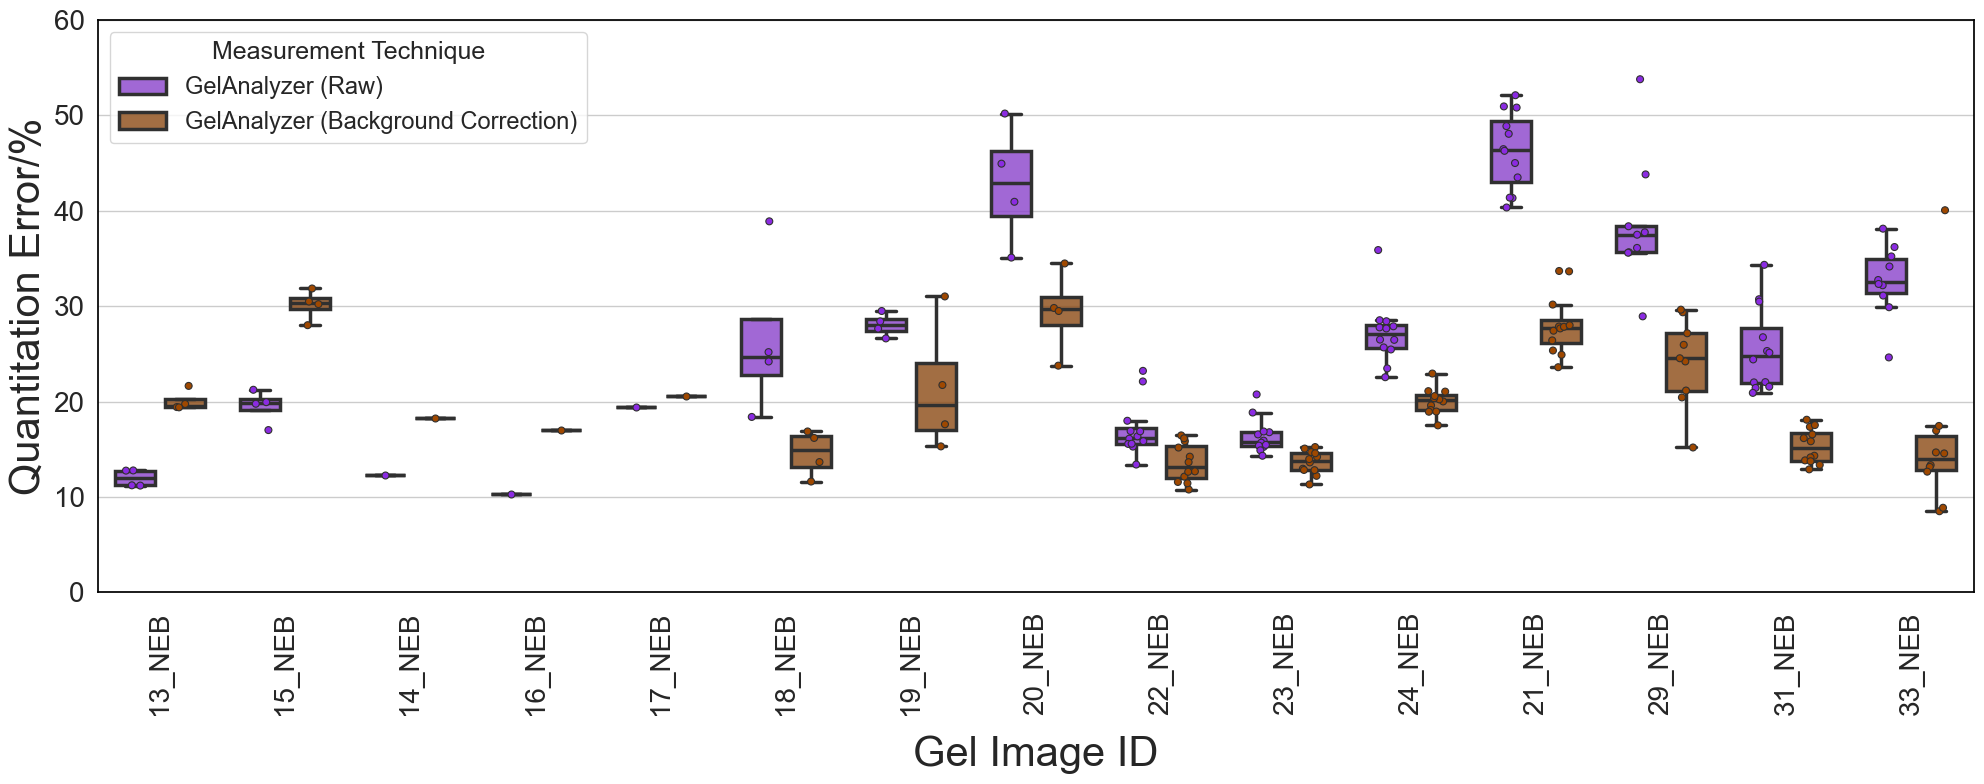

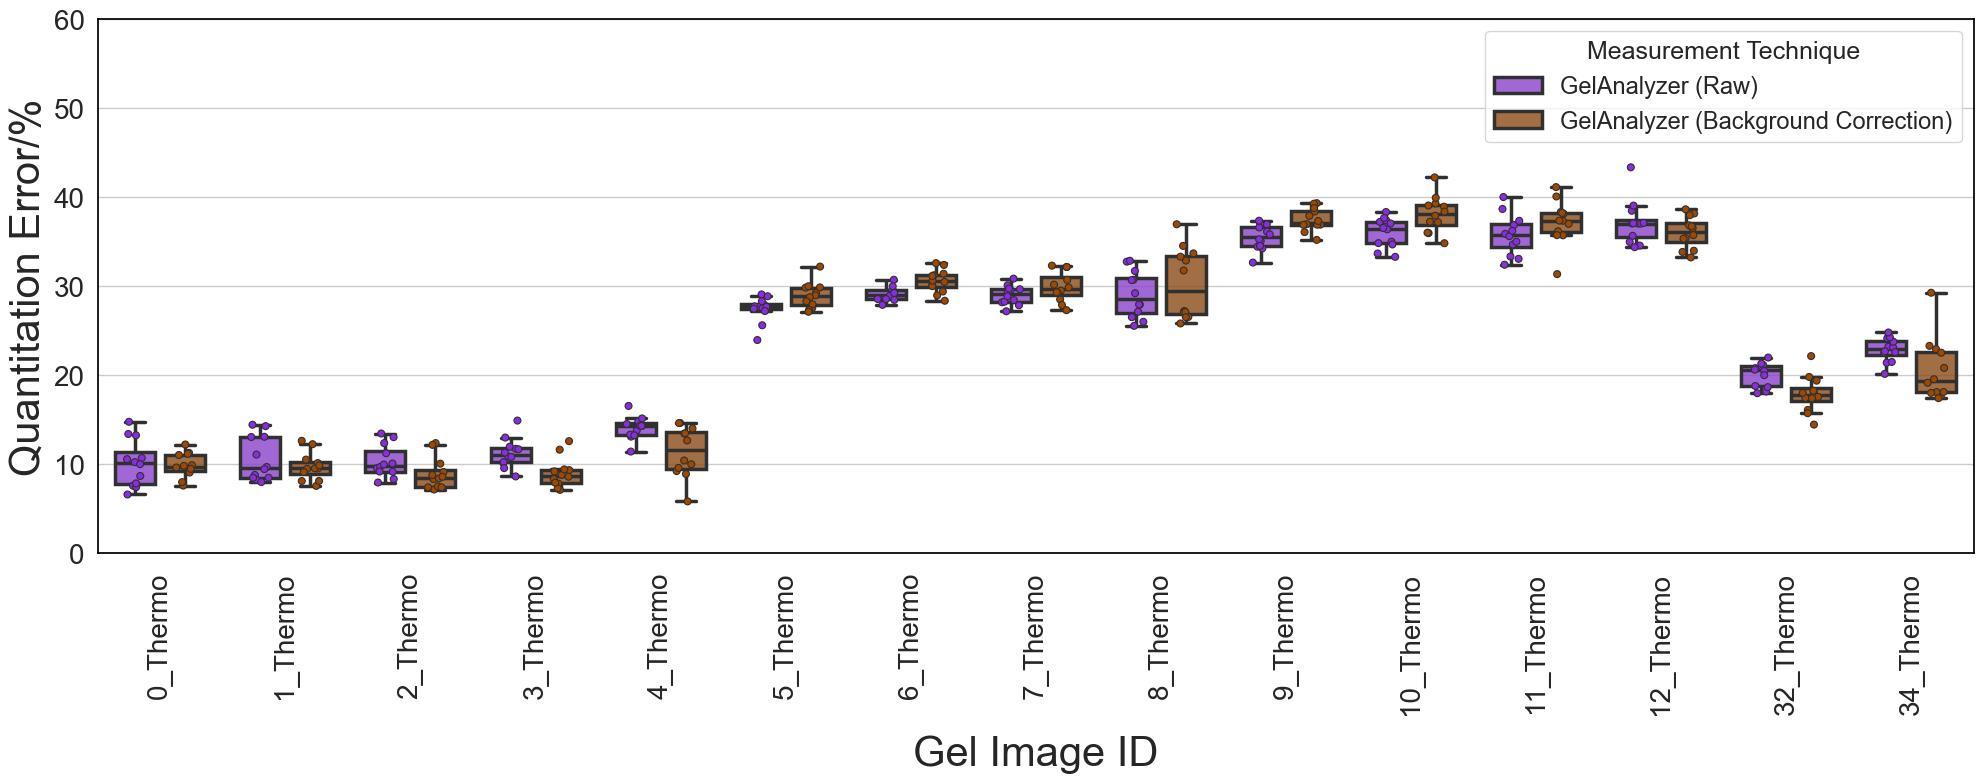

In [10]:
for l_target in ['NEB', 'ThermoFisher']:
    bdf = blind_df[blind_df['Ladder'] == l_target]
    if l_target == 'NEB':
        gel_based_order = ['13_NEB', '15_NEB', '14_NEB', '16_NEB', '17_NEB', '18_NEB', '19_NEB', '20_NEB', '22_NEB', '23_NEB', '24_NEB', '21_NEB', '29_NEB', '31_NEB', '33_NEB']
        # Create a mapping from the custom order
        order_mapping = {val: idx for idx, val in enumerate(gel_based_order)}
        # Sort using the custom order
        bdf['Order'] = bdf['Gel'].map(order_mapping)
        bdf = bdf.sort_values(by='Order').drop(columns='Order').reset_index(drop=True)

    # for now, random adjustment and additional erosion/dilation are unneccessary.  Will add these to supp info.
    df_adjusted = bdf.drop(columns=['Pixel Average', 
                                     'random adjustment 1', 
                                     'erosion 2', 'dilation 2', 
                                     'Local Corrected Volume', 
                                     'erosion 1',
                                     'dilation 1',
                                     # 'GA-Raw-Vol',
                                     # 'GA-BC-Vol',
                                    'Raw',
                                     'RB Corrected',
                                     'Global Corrected Volume', 
                                     'Ladder'])
    # df_adjusted.rename(columns={"Raw":"Manual Segmentation"}, inplace=True)
    # df_adjusted.rename(columns={"Raw":"Manual Segmentation", 
    #                             "RB Corrected":"Manual + Rolling Ball Background Correction"}, inplace=True)
    df_adjusted.rename(columns={
                                "GA-Raw-Vol":"GelAnalyzer (Raw)", 
                                "GA-BC-Vol":"GelAnalyzer (Background Correction)"}, inplace=True)
    df_melted = pd.melt(df_adjusted, id_vars=['Gel'], var_name='Values')
    plt.figure(figsize=(20,8))
    
    sel_palette = "bright"
    sel_palette = ['#8b2be2', '#9f4800']
    sns.set(style="whitegrid")
    # ax = sns.violinplot(x='Ladder', y='value', hue='Values', data=df_melted, legend=False, fill=False, palette=sel_palette)
    ax = sns.boxplot(x='Gel', y='value', hue='Values', data=df_melted, showfliers=False, 
                     gap=.2, palette=sel_palette, linewidth=2.5)
    ax.tick_params(axis='x', labelsize=20, size=10)
    ax.set_xticks(ax.get_xticks()) # just to silence annoying warning
    for patch in ax.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8))
    # sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.1, legend=False, dodge=True, alpha=0.4, marker="$\circ$", palette="dark") 
    sns.stripplot(x='Gel', y='value', hue='Values', data=df_melted, jitter=0.15, legend=False, dodge=True, 
                  alpha=1.0, marker="o", palette=sel_palette, linewidth=0.8) 
    
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    # sns.despine(offset=10, trim=False)
    plt.xlabel('Gel Image ID', fontsize=30, labelpad=15)
    plt.ylabel('Quantitation Error/%', fontsize=30)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=90)
    plt.ylim([0,60])
    ax.legend(title='Measurement Technique', fontsize=17, title_fontsize=18)
    plt.tight_layout()
    plt.savefig('/Users/matt/Desktop/gel_comp_seg_dataset_GA_%s.pdf' % l_target)
    pass

/var/folders/bf/svk708557cgcqbh0gyt7f3gw0000gn/T/ipykernel_60846/2545913364.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdf['Order'] = bdf['Gel'].map(order_mapping)


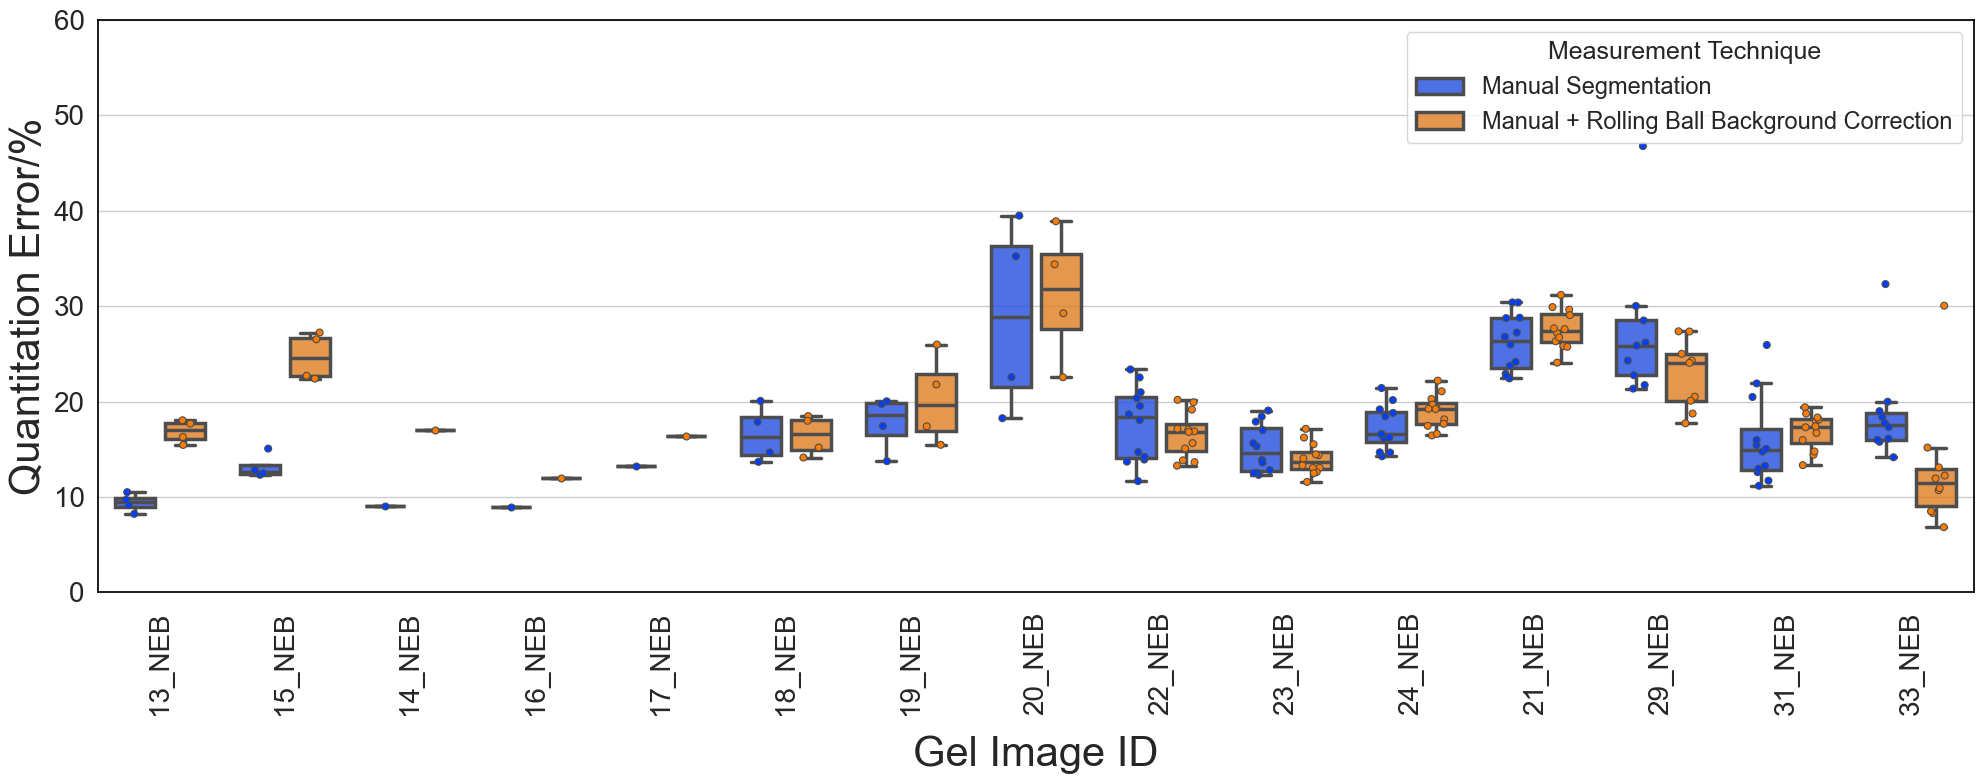

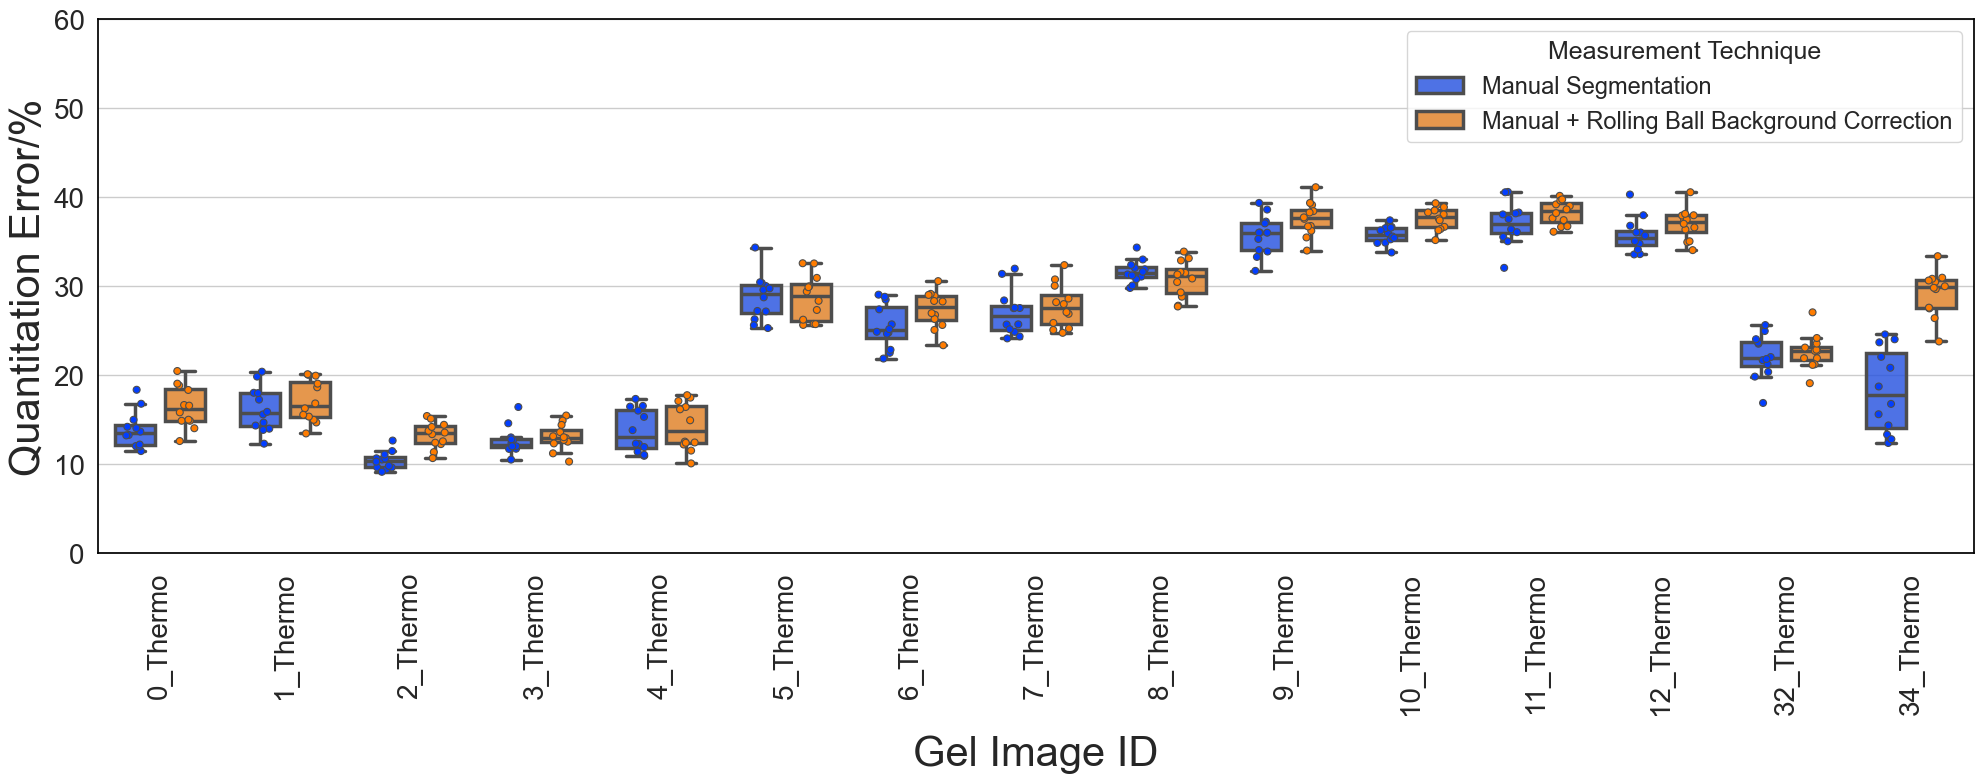

In [82]:

for l_target in ['NEB', 'ThermoFisher']:
    bdf = blind_df[blind_df['Ladder'] == l_target]
    if l_target == 'NEB':
        gel_based_order = ['13_NEB', '15_NEB', '14_NEB', '16_NEB', '17_NEB', '18_NEB', '19_NEB', '20_NEB', '22_NEB', '23_NEB', '24_NEB', '21_NEB', '29_NEB', '31_NEB', '33_NEB']
        # Create a mapping from the custom order
        order_mapping = {val: idx for idx, val in enumerate(gel_based_order)}
        # Sort using the custom order
        bdf['Order'] = bdf['Gel'].map(order_mapping)
        bdf = bdf.sort_values(by='Order').drop(columns='Order').reset_index(drop=True)
        
    # for now, random adjustment and additional erosion/dilation are unneccessary.  Will add these to supp info.
    df_adjusted = bdf.drop(columns=['Pixel Average', 
                                     'random adjustment 1', 
                                     'erosion 2', 'dilation 2', 
                                     'Local Corrected Volume', 
                                     'erosion 1',
                                     'dilation 1',
                                     'GA-Raw-Vol',
                                     'GA-BC-Vol',
                                     # 'RB Corrected',
                                     'Global Corrected Volume', 
                                     'Ladder'])
    # df_adjusted.rename(columns={"Raw":"Manual Segmentation"}, inplace=True)
    df_adjusted.rename(columns={"Raw":"Manual Segmentation", 
                                "RB Corrected":"Manual + Rolling Ball Background Correction"}, inplace=True)
    # df_adjusted.rename(columns={"Raw":"Manual Segmentation", 
    #                             "RB Corrected":"Manual + Rolling Ball Background Correction",
    #                             "GA-Raw-Vol":"GelAnalyzer (Raw)", 
    #                             "GA-BC-Vol":"GelAnalyzer (Background Correction)"}, inplace=True)
    df_melted = pd.melt(df_adjusted, id_vars=['Gel'], var_name='Values')
    plt.figure(figsize=(20,8))
    
    sel_palette = "bright"
    sel_palette = ['#023eff', '#ff7c00']
    sns.set(style="whitegrid")
    # ax = sns.violinplot(x='Ladder', y='value', hue='Values', data=df_melted, legend=False, fill=False, palette=sel_palette)
    ax = sns.boxplot(x='Gel', y='value', hue='Values', data=df_melted, showfliers=False, 
                     gap=.2, palette=sel_palette, linewidth=2.5)
    ax.tick_params(axis='x', labelsize=20, size=10)
    ax.set_xticks(ax.get_xticks()) # just to silence annoying warning
    for patch in ax.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8))
    # sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.1, legend=False, dodge=True, alpha=0.4, marker="$\circ$", palette="dark") 
    sns.stripplot(x='Gel', y='value', hue='Values', data=df_melted, jitter=0.15, legend=False, dodge=True, 
                  alpha=1.0, marker="o", palette=sel_palette, linewidth=0.8) 
    
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    # sns.despine(offset=10, trim=False)
    plt.xlabel('Gel Image ID', fontsize=30, labelpad=15)
    plt.ylabel('Quantitation Error/%', fontsize=30)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=90)
    plt.ylim([0,60])
    ax.legend(title='Measurement Technique', fontsize=17, title_fontsize=18)
    plt.tight_layout()
    plt.savefig('/Users/matt/Desktop/gel_comp_seg_dataset_%s.pdf' % l_target)
    pass

## Plot 2 - Comparing Background Correction Methods - Figure 1B Part 2

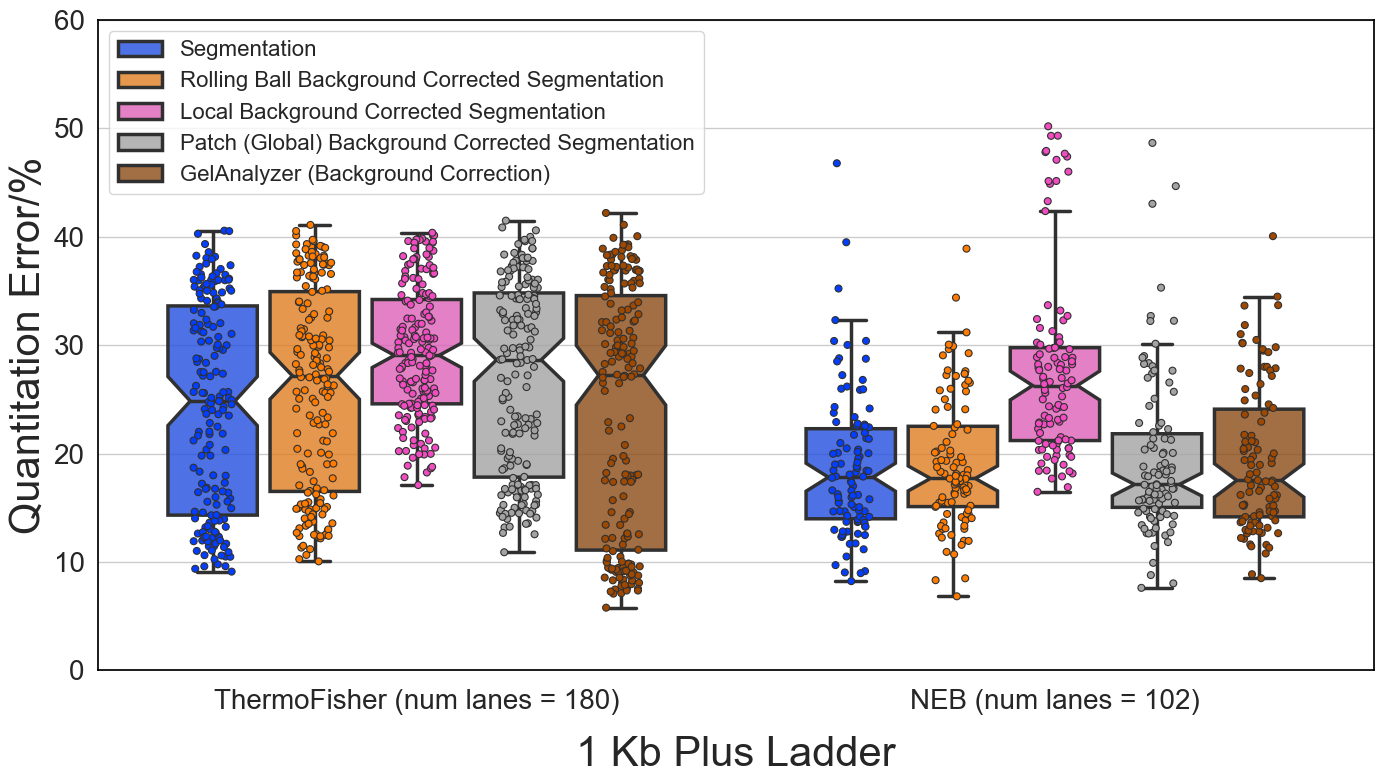

In [42]:

# for now, random adjustment and additional erosion/dilation are unneccessary.  Will add these to supp info.
df_adjusted = blind_df.drop(columns=['Pixel Average', 'random adjustment 1', 'erosion 2', 'dilation 2', 'erosion 1', 'dilation 1', 'GA-Raw-Vol', 'GA-BC-Vol', 'Gel'])
df_adjusted['GA-BC-Vol'] = blind_df['GA-BC-Vol']
df_adjusted.rename(columns={"Raw":"Segmentation", 
                            "RB Corrected":"Rolling Ball Background Corrected Segmentation",
                            "Local Corrected Volume":"Local Background Corrected Segmentation",
                            "Global Corrected Volume":"Patch (Global) Background Corrected Segmentation",
                            "GA-BC-Vol":"GelAnalyzer (Background Correction)"}, inplace=True)
df_melted = pd.melt(df_adjusted, id_vars=['Ladder'], var_name='Values')
plt.figure(figsize=(14,8))

sel_palette = ['#023eff', '#ff7c00', '#f14cc1', '#a3a3a3', '#9f4800']
sns.set(style="whitegrid")
# ax = sns.violinplot(x='Ladder', y='value', hue='Values', data=df_melted, legend=False, fill=False, palette=sel_palette)
ax = sns.boxplot(x='Ladder', y='value', hue='Values', data=df_melted, showfliers=False, 
                 notch=True, gap=.4, widths=[0.14, 0.14], palette=sel_palette, linewidth=2.5)
ax.tick_params(axis='x', labelsize=20, size=10)
ax.set_xticks(ax.get_xticks()) # just to silence annoying warning
ax.set_xticklabels(['ThermoFisher (num lanes = %s)' % sum(blind_df["Ladder"] == "ThermoFisher"),'NEB (num lanes = %s)' % sum(blind_df["Ladder"] == "NEB")])
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
# sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.1, legend=False, dodge=True, alpha=0.4, marker="$\circ$", palette="dark") 
sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.15, legend=False, dodge=True, 
              alpha=1.0, marker="o", palette=sel_palette, linewidth=0.8) 

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
# sns.despine(offset=10, trim=False)
plt.xlabel('1 Kb Plus Ladder', fontsize=30, labelpad=15)
plt.ylabel('Quantitation Error/%', fontsize=30)
plt.yticks(fontsize=20)
plt.ylim([0,60])
ax.legend(fontsize=16)
plt.tight_layout()
plt.savefig('/Users/matt/Desktop/ladder_comp_seg_human_dataset_background_correction.pdf')
pass

## Plot 3 - Extended Erosion/Dilation Analysis - Extended Data Figure 2B

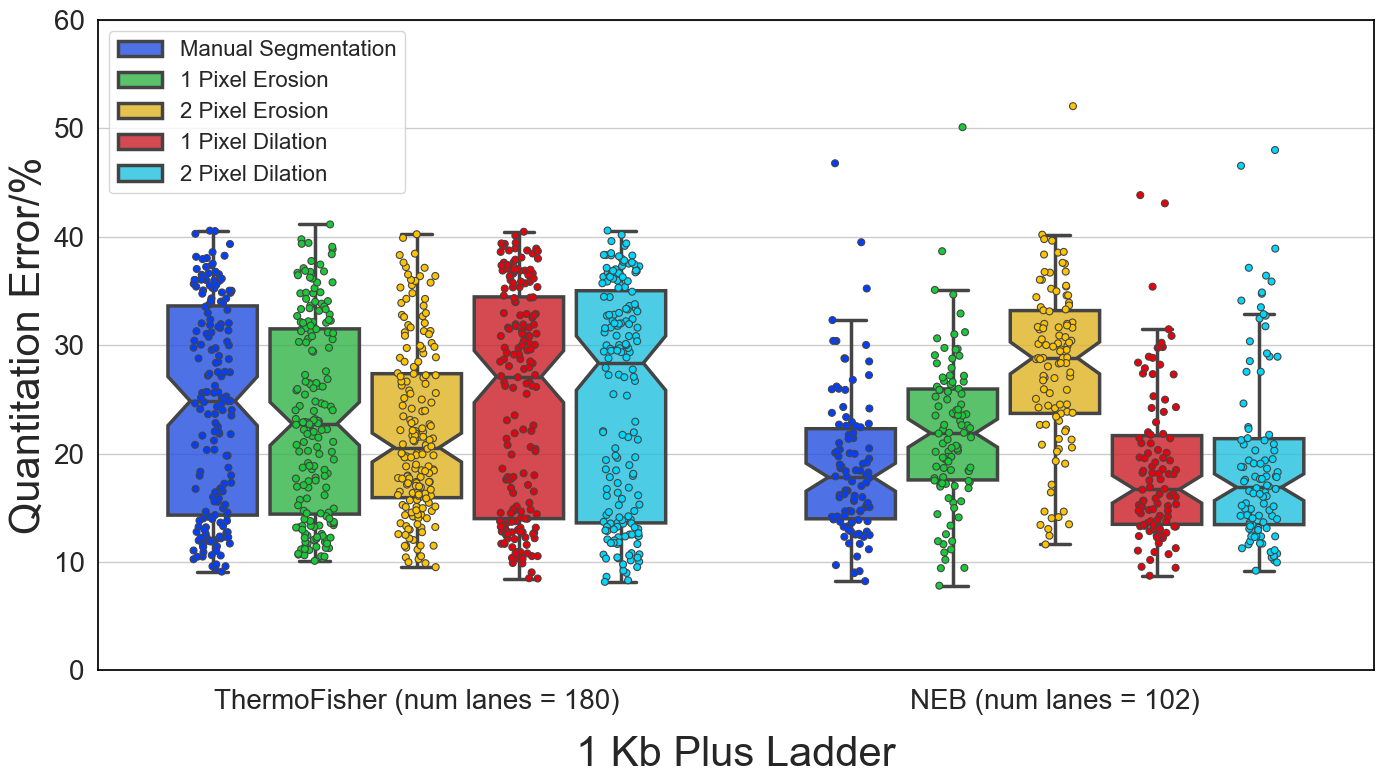

In [43]:

# for now, random adjustment and additional erosion/dilation are unneccessary.  Will add these to supp info.
df_adjusted = blind_df.drop(columns=['Pixel Average', 'RB Corrected', 'Local Corrected Volume', 'Global Corrected Volume', 'GA-Raw-Vol', 'GA-BC-Vol', 'Gel', 'random adjustment 1'])
df_adjusted.rename(columns={"Raw":"Manual Segmentation", "RB Corrected":"Manual + Rolling Ball Background Correction", 
                            "erosion 1":"1 Pixel Erosion", "dilation 1":"1 Pixel Dilation", "GA-Raw-Vol":"GelAnalyzer (Raw)",
                            "GA-BC-Vol":"GelAnalyzer (Background Correction)",
                           "erosion 2": "2 Pixel Erosion", "dilation 2":"2 Pixel Dilation"}, inplace=True)
df_melted = pd.melt(df_adjusted, id_vars=['Ladder'], var_name='Values')
plt.figure(figsize=(14,8))

sel_palette = ['#023eff', '#1ac938', '#ffc400','#e8000b', '#00d7ff']
sns.set(style="whitegrid")
# ax = sns.violinplot(x='Ladder', y='value', hue='Values', data=df_melted, legend=False, fill=False, palette=sel_palette)
ax = sns.boxplot(x='Ladder', y='value', hue='Values', data=df_melted, showfliers=False, 
                 notch=True, gap=.4, widths=[0.14, 0.14], palette=sel_palette, linewidth=2.5)
ax.tick_params(axis='x', labelsize=20, size=10)
ax.set_xticks(ax.get_xticks()) # just to silence annoying warning
ax.set_xticklabels(['ThermoFisher (num lanes = %s)' % sum(blind_df["Ladder"] == "ThermoFisher"),'NEB (num lanes = %s)' % sum(blind_df["Ladder"] == "NEB")])
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
# sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.1, legend=False, dodge=True, alpha=0.4, marker="$\circ$", palette="dark") 
sns.stripplot(x='Ladder', y='value', hue='Values', data=df_melted, jitter=0.15, legend=False, dodge=True, 
              alpha=1.0, marker="o", palette=sel_palette, linewidth=0.8) 

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
# sns.despine(offset=10, trim=False)
plt.xlabel('1 Kb Plus Ladder', fontsize=30, labelpad=15)
plt.ylabel('Quantitation Error/%', fontsize=30)
plt.yticks(fontsize=20)
plt.ylim([0,60])
ax.legend(fontsize=16)
plt.tight_layout()
plt.savefig('/Users/matt/Desktop/ladder_comp_seg_human_dataset_extended_erosion_dilation.pdf')
pass

## Stat Testing (t-test with paired samples) - Supplementary Data

In [90]:
import itertools

all_interesting_cols = ['Raw', 'RB Corrected', 'Global Corrected Volume', 'Local Corrected Volume', 'erosion 1', 'dilation 1', 'GA-Raw-Vol', 'GA-BC-Vol']
visual_dict = {"Raw":"Manual Segmentation", 
                "RB Corrected":"Manual + Rolling Ball Background Correction",
                "GA-Raw-Vol":"GelAnalyzer (Raw)", 
                "GA-BC-Vol":"GelAnalyzer (Background Correction)",
                "Local Corrected Volume":"Local Background Correction",
                "Global Corrected Volume":"Patch (Global) Background Correction",
                "erosion 1":"1 Pixel Erosion",
                "dilation 1":"1 Pixel Dilation"}
stat_dfs = {}
for ladder in ['NEB', 'ThermoFisher', 'all']:
    if ladder == 'all':
        sel_df = blind_df
    else:
        sel_df = blind_df[blind_df['Ladder'] == ladder]
    all_tstats = None
    for (s1, s2) in itertools.combinations(all_interesting_cols, 2):
        res = pingouin.ttest(sel_df[s1], sel_df[s2], paired=True)
        res = res.rename(index={'T-test': f'{visual_dict[s1]} || {visual_dict[s2]}'})
        if all_tstats is None:
            all_tstats = res
        else:
            all_tstats = pd.concat([all_tstats, res])
    stat_dfs[ladder] = all_tstats    

In [91]:
stat_dfs['NEB'].to_csv('/Users/matt/Desktop/two_sided_stats_NEB.csv') 
stat_dfs['NEB']

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
Manual Segmentation || Manual + Rolling Ball Background Correction,-0.566156,101,two-sided,5.725437e-01,"[-1.3, 0.72]",0.045454,0.128,0.074004
Manual Segmentation || Patch (Global) Background Correction,-1.697984,101,two-sided,9.258988e-02,"[-1.41, 0.11]",0.093266,0.438,0.154128
Manual Segmentation || Local Background Correction,-12.908473,101,two-sided,4.235525e-23,"[-10.37, -7.61]",1.162624,1.018e+20,1.000000
Manual Segmentation || 1 Pixel Erosion,-12.693544,101,two-sided,1.216850e-22,"[-3.66, -2.67]",0.474360,3.619e+19,0.997322
Manual Segmentation || 1 Pixel Dilation,0.522404,101,two-sided,6.025332e-01,"[-0.24, 0.41]",0.012627,0.125,0.051830
Manual Segmentation || GelAnalyzer (Raw),-12.260900,101,two-sided,1.031418e-21,"[-10.32, -7.45]",0.964079,4.464e+18,1.000000
Manual Segmentation || GelAnalyzer (Background Correction),-1.072498,101,two-sided,2.860522e-01,"[-1.93, 0.58]",0.101315,0.191,0.173433
Manual + Rolling Ball Background Correction || Patch (Global) Background Correction,-0.879562,101,two-sided,3.811843e-01,"[-1.18, 0.46]",0.054420,0.16,0.084585
Manual + Rolling Ball Background Correction || Local Background Correction,-14.816515,101,two-sided,4.476050e-27,"[-9.87, -7.54]",1.167623,8.093e+23,1.000000
Manual + Rolling Ball Background Correction || 1 Pixel Erosion,-4.525419,101,two-sided,1.649511e-05,"[-4.14, -1.62]",0.453377,979.219,0.994988


In [92]:
stat_dfs['ThermoFisher'].to_csv('/Users/matt/Desktop/two_sided_stats_thermo.csv') 
stat_dfs['ThermoFisher']

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
Manual Segmentation || Manual + Rolling Ball Background Correction,-7.225791,179,two-sided,1.385362e-11,"[-2.25, -1.28]",0.186887,5.388e+08,0.703306
Manual Segmentation || Patch (Global) Background Correction,-11.076526,179,two-sided,4.748630e-22,"[-3.15, -2.2]",0.290789,9.074e+18,0.972594
Manual Segmentation || Local Background Correction,-11.960241,179,two-sided,1.317351e-24,"[-5.92, -4.25]",0.637327,2.955e+21,1.000000
Manual Segmentation || 1 Pixel Erosion,6.107155,179,two-sided,6.151982e-09,"[0.71, 1.39]",0.113768,1.487e+06,0.329571
Manual Segmentation || 1 Pixel Dilation,-4.673502,179,two-sided,5.804858e-06,"[-0.87, -0.35]",0.061725,2134.758,0.130608
Manual Segmentation || GelAnalyzer (Raw),1.520327,179,two-sided,1.301932e-01,"[-0.12, 0.95]",0.041771,0.258,0.086287
Manual Segmentation || GelAnalyzer (Background Correction),1.798351,179,two-sided,7.380639e-02,"[-0.06, 1.2]",0.054090,0.403,0.111491
Manual + Rolling Ball Background Correction || Patch (Global) Background Correction,-2.668740,179,two-sided,8.313269e-03,"[-1.58, -0.24]",0.100256,2.592,0.267423
Manual + Rolling Ball Background Correction || Local Background Correction,-9.403605,179,two-sided,2.545945e-17,"[-4.02, -2.62]",0.424445,2.098e+14,0.999894
Manual + Rolling Ball Background Correction || 1 Pixel Erosion,10.639956,179,two-sided,8.470596e-21,"[2.3, 3.34]",0.309216,5.363e+17,0.984854


In [60]:
stat_dfs['all']

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
Raw||RB Corrected,-5.040102,281,two-sided,8.345861e-07,"[-1.71, -0.75]",0.137287,1.132e+04,0.632173
Raw||Global Corrected Volume,-9.041718,281,two-sided,2.591658e-17,"[-2.37, -1.52]",0.215239,1.849e+14,0.949718
Raw||Local Corrected Volume,-16.828058,281,two-sided,1.968062e-44,"[-7.26, -5.74]",0.800704,1.081e+41,1.000000
Raw||erosion 1,-2.540287,281,two-sided,1.161469e-02,"[-0.84, -0.11]",0.055001,1.57,0.151274
Raw||dilation 1,-3.445047,281,two-sided,6.581164e-04,"[-0.56, -0.15]",0.038487,21.06,0.098715
Raw||GA-Raw-Vol,-7.164629,281,two-sided,6.872683e-12,"[-3.76, -2.14]",0.297504,9.258e+08,0.998731
Raw||GA-BC-Vol,0.391271,281,two-sided,6.958934e-01,"[-0.48, 0.72]",0.012464,0.072,0.054999
RB Corrected||Global Corrected Volume,-2.697848,281,two-sided,7.400998e-03,"[-1.23, -0.19]",0.079259,2.339,0.263704
RB Corrected||Local Corrected Volume,-15.246154,281,two-sided,1.164846e-38,"[-5.95, -4.59]",0.653881,2.081e+35,1.000000
RB Corrected||erosion 1,2.306043,281,two-sided,2.183619e-02,"[0.11, 1.4]",0.088484,0.905,0.316209


In [80]:
import itertools

all_interesting_cols = ['Raw', 'RB Corrected', 'Global Corrected Volume', 'Local Corrected Volume']
visual_dict = {"Raw":"Manual Segmentation", 
                "RB Corrected":"Manual + Rolling Ball Background Correction",
                "GA-Raw-Vol":"GelAnalyzer (Raw)", 
                "GA-BC-Vol":"GelAnalyzer (Background Correction)",
                "Local Corrected Volume":"Local Background Correction",
                "Global Corrected Volume":"Patch (Global) Background Correction",
                "erosion 1":"1 Pixel Erosion",
                "dilation 1":"1 Pixel Dilation"}
one_side_stat_dfs = {}
for ladder in ['NEB', 'ThermoFisher', 'all']:
    if ladder == 'all':
        sel_df = blind_df
    else:
        sel_df = blind_df[blind_df['Ladder'] == ladder]
    all_tstats = None
    for (s1, s2) in itertools.combinations(all_interesting_cols, 2):
        if s1 != 'Raw':
            continue
        res = pingouin.ttest(sel_df[s1], sel_df[s2], alternative='less', paired=True)
        res = res.rename(index={'T-test': f'{visual_dict[s1]} || {visual_dict[s2]}'})
        if all_tstats is None:
            all_tstats = res
        else:
            all_tstats = pd.concat([all_tstats, res])
    one_side_stat_dfs[ladder] = all_tstats    

In [85]:
one_side_stat_dfs['NEB'].to_csv('/Users/matt/Desktop/one_side_NEB.csv') 
one_side_stat_dfs['NEB']

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
Manual Segmentation || Manual + Rolling Ball Background Correction,-0.566156,101,less,2.862718e-01,"[-inf, 0.56]",0.045454,0.256,0.117248
Manual Segmentation || Patch (Global) Background Correction,-1.697984,101,less,4.629494e-02,"[-inf, -0.01]",0.093266,0.876,0.239095
Manual Segmentation || Local Background Correction,-12.908473,101,less,2.117763e-23,"[-inf, -7.83]",1.162624,2.035e+20,1.000000


In [86]:
one_side_stat_dfs['ThermoFisher'].to_csv('/Users/matt/Desktop/one_side_thermo.csv') 
one_side_stat_dfs['ThermoFisher'] 

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
Manual Segmentation || Manual + Rolling Ball Background Correction,-7.225791,179,less,6.926808e-12,"[-inf, -1.36]",0.186887,1.078e+09,0.803173
Manual Segmentation || Patch (Global) Background Correction,-11.076526,179,less,2.374315e-22,"[-inf, -2.28]",0.290789,1.815e+19,0.987509
Manual Segmentation || Local Background Correction,-11.960241,179,less,6.586754e-25,"[-inf, -4.38]",0.637327,5.911e+21,1.000000


## Sandbox for Additional Investigations into Raw vs Background Correction

In [82]:
np.random.seed(12)

def normalize(series):
    return (series) / (series.max())
    
for index, big_key in enumerate(data_pack.keys()):
    sel_df = copy.copy(data_pack[big_key])
    sel_df['Gel Name'] = [big_key]*len(sel_df)
    sel_df['Ladder'] = [big_key.split('_')[-1]]*len(sel_df)
    
    sel_df['norm_Raw'] = sel_df.groupby('Lane ID')['Raw'].transform(normalize)
    sel_df['norm_RB'] = sel_df.groupby('Lane ID')['RB Corrected'].transform(normalize)
    sel_df['norm_GA'] = sel_df.groupby('Lane ID')['GA-Raw-Vol'].transform(normalize)
    sel_df['norm_GABC'] = sel_df.groupby('Lane ID')['GA-BC-Vol'].transform(normalize)
    sel_df['norm_Ref'] = sel_df.groupby('Lane ID')['Ref.'].transform(normalize)

    sel_df['E-Raw'] = np.abs(sel_df['norm_Ref'] - sel_df['norm_Raw'])
    sel_df['E-RB'] = np.abs(sel_df['norm_Ref'] - sel_df['norm_RB'])
    sel_df['E-GA'] = np.abs(sel_df['norm_Ref'] - sel_df['norm_GA'])
    sel_df['E-GABC'] = np.abs(sel_df['norm_Ref'] - sel_df['norm_GABC'])
    
    sel_df['NE-Raw'] = np.abs((sel_df['norm_Ref'] - sel_df['norm_Raw'])/sel_df['norm_Ref'])
    sel_df['NE-RB'] = np.abs((sel_df['norm_Ref'] - sel_df['norm_RB'])/sel_df['norm_Ref'])
    sel_df['NE-GA'] = np.abs((sel_df['norm_Ref'] - sel_df['norm_GA'])/sel_df['norm_Ref'])
    sel_df['NE-GABC'] = np.abs((sel_df['norm_Ref'] - sel_df['norm_GABC'])/sel_df['norm_Ref'])
    if index == 0:
        combined_df = sel_df
    else:
        combined_df = pd.concat([combined_df, sel_df], ignore_index=True)


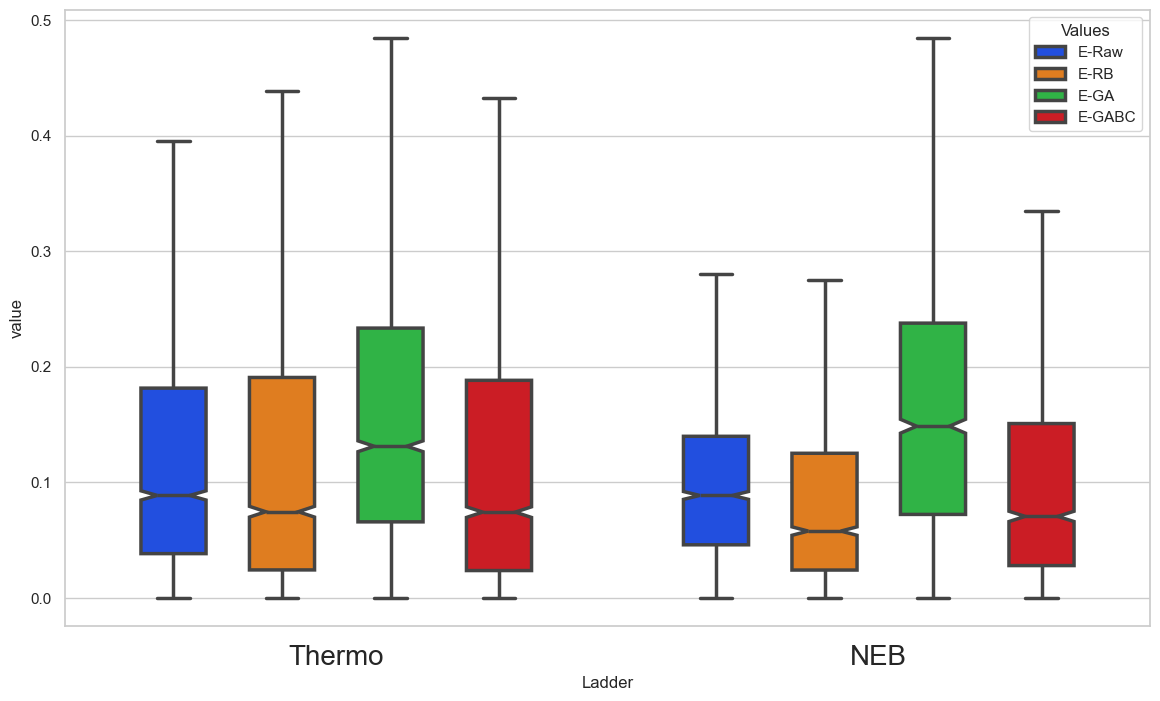

In [84]:
# df_adjusted = combined_df[['norm_Raw', 'norm_RB', 'norm_GA', 'norm_GABC', 'norm_Ref', 'Ladder']]
df_adjusted = combined_df[['E-Raw', 'E-RB', 'E-GA', 'E-GABC', 'Ladder']]
# df_adjusted = combined_df[['NE-Raw', 'NE-RB', 'NE-GA', 'NE-GABC', 'Ladder']]

df_melted = pd.melt(df_adjusted, id_vars=['Ladder'], var_name='Values')
plt.figure(figsize=(14,8))

sel_palette = "bright"
sns.set(style="whitegrid")
# ax = sns.violinplot(x='Ladder', y='value', hue='Values', data=df_melted, legend=False, fill=False, palette=sel_palette)
ax = sns.boxplot(x='Ladder', y='value', hue='Values', data=df_melted, showfliers=False, 
                 notch=True, gap=.4, widths=[0.12, 0.12], palette=sel_palette, linewidth=2.5)
ax.tick_params(axis='x', labelsize=20, size=10)

### Individual Gel Testing

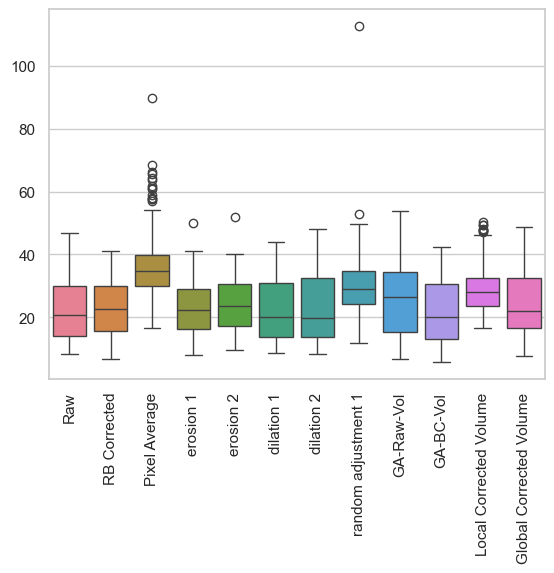

In [500]:
ax = sns.boxplot(data=blind_df)
ax.tick_params(axis='x', rotation=90)

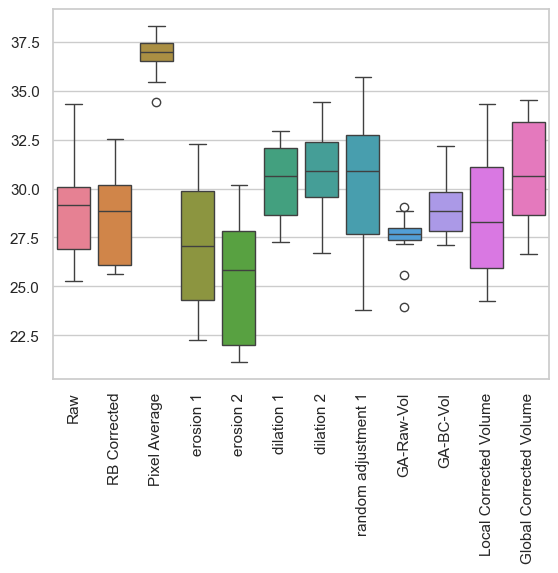

In [508]:
ax = sns.boxplot(data=blind_df[descriptor_df['Gel Name'] == '5_Thermo'])
ax.tick_params(axis='x', rotation=90)

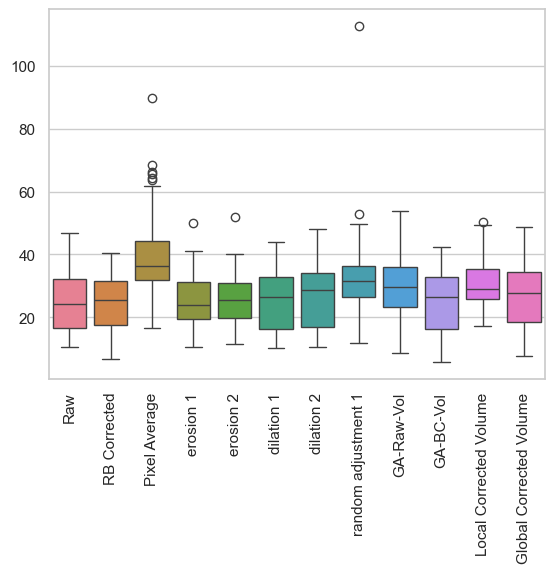

In [479]:
ax = sns.boxplot(data=blind_df[descriptor_df['Gel Intensity'] == 'High'])
ax.tick_params(axis='x', rotation=90)

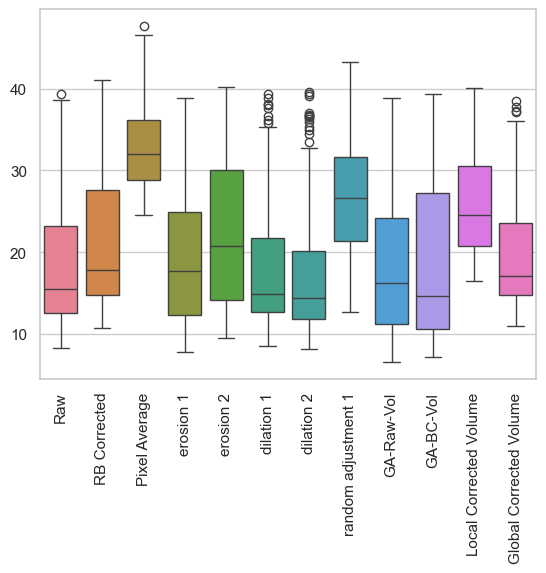

In [480]:
ax = sns.boxplot(data=blind_df[descriptor_df['Gel Intensity'] == 'Low'])
ax.tick_params(axis='x', rotation=90)

In [524]:
print(sns.color_palette('bright').as_hex())
sns.color_palette('bright')

['#023eff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', '#9f4800', '#f14cc1', '#a3a3a3', '#ffc400', '#00d7ff']


[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]